In [1]:
!python3 -m pip install pandas
!python3 -m pip install 'pycaret[full]'
!python3 -m pip install 'pycaret[tuners]'
!python3 -m pip install xgboost
!python3 -m pip install scikit-optimize
!python3 -m pip install joblib
!python3 -m pip install 'ray[tune]'
!python3 -m pip install 'tune[search]'


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached dask-2024.7.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached distributed-2024.7.1-py3-none-any.whl.metadata (3.4 kB)
INFO: pip is looking at multiple versions of fugue[dask] to determine which version is compatible with other requirements. This could take a while.
  Using cached fugue-0.8.7-py3-none-any.whl.metadata (17 kB)
  Using cached importlib_metadata-7.2.1-py3-none-any.whl.metadata (4.6 kB)
INFO: pip is looking at multiple versions of pandas[parquet] to determine which version is compatible with other requirements. This could take a while.
Using cached dask-2024.7.1-py3-none-any.whl (1.2 MB)
Using cached distributed-2024.7.1-py3-none-any.whl (1.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 51.6 MB/s eta 0:00:00a 0:0

In [96]:
pip install -U git+https://github.com/ray-project/tune-sklearn.git && pip install 'ray[tune]'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/ray-project/tune-sklearn.git to /private/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/pip-req-build-8ksunnlf
  Running command git clone --filter=blob:none --quiet https://github.com/ray-project/tune-sklearn.git /private/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/pip-req-build-8ksunnlf
  Resolved https://github.com/ray-project/tune-sklearn.git to commit 75e6a9da1548a8d1a31a7463c997b0612a9211c1
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [143]:
from pycaret.classification import *
import pandas as pd
import numpy as np

<h2>1. 데이터 로드 및 전처리</h2>

In [153]:
# 1. 데이터 로드

data = pd.read_csv('/Users/jeahyukjeong/Desktop/CS_Project/ASD/ASD_na_deleted/MCHAT.csv')

# Shap value 정보 기반 칼럼 제거
data = data.drop(['1st_Screening_ASD_Criteria', 'Congenital_Genetic_Disorder', 'History_of_Brain_Damage', 'Seizure_or_Neurological_disease', 'InspectDate', 'Total_Score'], axis = 1)
# https://github.com/skwgbobf/ASD_Kaggle/blob/main/4.Kaggle1_%20BERT%20Classification.ipynb

# train test 8:2로 나눕니다.
np.random.seed(112)
train, test = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data))])

print(len(train), len(test))

114 29


<h2>2. 전처리 </h2>
categorical data 숫자형으로 변환 + 학습에 관련 없는 칼럼 분리 <br>
https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook


In [154]:
# 2. Preprocess

# Categorical Data 숫자형으로 변환

# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook
from sklearn import preprocessing

# 데이터 칼럼 추출
cat_cols = list(train.select_dtypes('object').columns.values)

# 전처리 과정을 위해서 train과 test 셋들을 잠시 합칩니다.
df = pd.concat([train, test], axis=0)

# 데이터 타입을 모두 숫자형으로 통일
label_encoder = preprocessing.LabelEncoder()
for col in cat_cols:
    df[col]= label_encoder.fit_transform(df[col])

# train test를 다시 8:2로 나눕니다
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

In [155]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Subject_Id,29.0,1.137243e+09,1.552150e+08,1.023041e+09,1.023121e+09,1.024053e+09,1.323080e+09,1.623072e+09
Gender,29.0,6.551724e-01,4.837253e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Class/ASD,29.0,7.931034e-01,4.122508e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Family_History,29.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SurveyApplicableMonthAge,29.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Age,29.0,2.496552e+01,3.950432e+00,1.800000e+01,2.100000e+01,2.500000e+01,2.800000e+01,3.000000e+01
Q1,29.0,1.034483e-01,3.099340e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Q2,29.0,2.068966e-01,4.122508e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Q3,29.0,1.379310e-01,3.509312e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Q4,29.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [156]:
import enum
import random
import os

# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

# 사용할 시드값 변환 함수
def random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# 시드값, CV fold 개수, 훈련 조기중단 변수 설정
class Config(enum.Enum):
    SEED = 42
    N_FOLDS = 5
    EARLY_STOP = 300

random_seed(Config.SEED.value)

<h2>2. XGBoost Hypter Parameter 설명 </h2> 


XGBoost + SHAP (하이퍼 파라미터 사용) <br>
https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

DMatrix() 사용 불가능 - DMatrix는 모델 학습 속도 상승 효과만 있음 <br>
pycaret에서 early stopping method 사용 불가능 / xgboost에서만 가능 - 모델 학습 속도 사응 효과만 있음 <br>
https://xgboost.readthedocs.io/en/stable/python/python_api.html



In [165]:
# https://www.kaggle.com/code/santhoshkumarv/autism-xgboost-shap-values/notebook

# xgboost 하이퍼파라미터 세팅
xgb_params=  {'n_estimators':10000,
              'learning_rate': 0.002,
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'max_depth': 10,
              'alpha': 0.5108154566815425,
              'gamma': 1.9276236172849432,
              'reg_lambda': 11.40999855634382,
              'colsample_bytree': 0.705851334291963,
              'subsample': 0.8386116751473301,
              'min_child_weight': 2.5517043283716605,
              #'early_stopping_rounds': Config.EARLY_STOP.value, # 학습 도중 모델이 발전이 없을 때 학습을 멈출 수 있게 하는 파라미터들
              #'evals' = [(dtrain, 'train'), (deval, 'eval')],   # pycaret에서 사용 불가능 / xgboost에서만 가능
              #'verbose_eval': 1000, 

}

<h2> 3. Model definition and Training</h2>

Pycaret Classification <br>
https://www.kaggle.com/code/venkatkumar001/apc-3-pycaret-identify-best-algo-s/notebook

학습 모델: XGBoost <br>
evaludation 방식: Stratified K-fold Cross Validation 

In [166]:
# 3. Training

# https://www.kaggle.com/code/venkatkumar001/apc-3-pycaret-identify-best-algo-s/notebook

import xgboost as xgb

# 모델 생성에 사용될 설정
reg = setup(data=train, # 
           target= 'Class/ASD', # columns = [col for col in train.columns if col not in ['ID', 'age_desc', 'Class/ASD'] ] 
           session_id = Config.SEED.value, # random_state = Config.SEED.value
           verbose = False, # silent = True
           fold = Config.N_FOLDS.value, # n_splits = Config.F_FOLDS.value
           data_split_shuffle = True, # shuffle = True
           ignore_features = ['Subject_Id', 'SurveyApplicableMonthAge'] # columns = [col for col in train.columns if col not in ['ID', 'age_desc', 'Class/ASD'] ] 
           )

# 모델 생성: XGBoost + Stratified K-fold Cross-Validation 사용
xgboost = create_model(
    'xgboost',
    #**xgb_params # xgboost 모델에 hyper parameter 입력
    )



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8750,0.8646,1.0000,0.8571,0.9231,0.6000,0.6547
1,0.6875,0.7604,0.7500,0.8182,0.7826,0.2308,0.2335
2,0.8750,0.9583,0.9167,0.9167,0.9167,0.6667,0.6667
3,0.6250,0.8125,0.5833,0.8750,0.7000,0.2500,0.2887
4,0.8000,0.6818,1.0000,0.7857,0.8800,0.3284,0.4432
Mean,0.7725,0.8155,0.8500,0.8505,0.8405,0.4152,0.4573
Std,0.1007,0.0935,0.1616,0.0453,0.0863,0.1823,0.1797


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [167]:

# hyper parameter 튜닝 (Random Grid Search 사용)
tuned_xgboost = tune_model(
    xgboost,
    search_library = 'scikit-optimize',
    search_algorithm = 'bayesian'
    )

# 모델 예측
predict_value = tuned_xgboost.predict(test.drop(['Subject_Id', 'Class/ASD', 'SurveyApplicableMonthAge'], axis = 1)) # shap_preds = tuned_xgboost.predict(test)
predict_model(tuned_xgboost, data = test.drop(['Subject_Id', 'Class/ASD', 'SurveyApplicableMonthAge'], axis = 1))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7500,0.8542,1.0000,0.7500,0.8571,0.0000,0.0000
1,0.8125,0.8229,1.0000,0.8000,0.8889,0.3333,0.4472
2,0.7500,0.7292,1.0000,0.7500,0.8571,0.0000,0.0000
3,0.7500,0.8750,0.8333,0.8333,0.8333,0.3333,0.3333
4,0.8000,0.6364,1.0000,0.7857,0.8800,0.3284,0.4432
Mean,0.7725,0.7835,0.9667,0.7838,0.8633,0.1990,0.2447
Std,0.0278,0.0889,0.0667,0.0316,0.0195,0.1625,0.2040


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Gender,Family_History,Age,Q1,Q2,Q3,Q4,Q5,Q6,Q7,...,Q18,Q19,Q20,Q21,Q22,Q23,ethnicity,language_label,prediction_label,prediction_score
88,1,0.0,18.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1,0.6389
126,1,0.0,30.0,0,1,1,0,0,0,1,...,0,0,0,0,1,1,0,1.0,1,0.9632
21,0,0.0,24.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1,0.5076
57,0,0.0,28.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,1,0.9275
75,1,0.0,28.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.0,1,0.8525
32,0,0.0,18.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1,0.6439
137,1,0.0,29.0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1.0,1,0.9632
59,0,0.0,27.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0.8647
63,0,0.0,24.0,1,1,0,0,0,1,0,...,0,0,0,0,0,1,0,1.0,1,0.9863
128,1,0.0,28.0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1.0,1,0.9242


<h2>4. Visualization</h2>

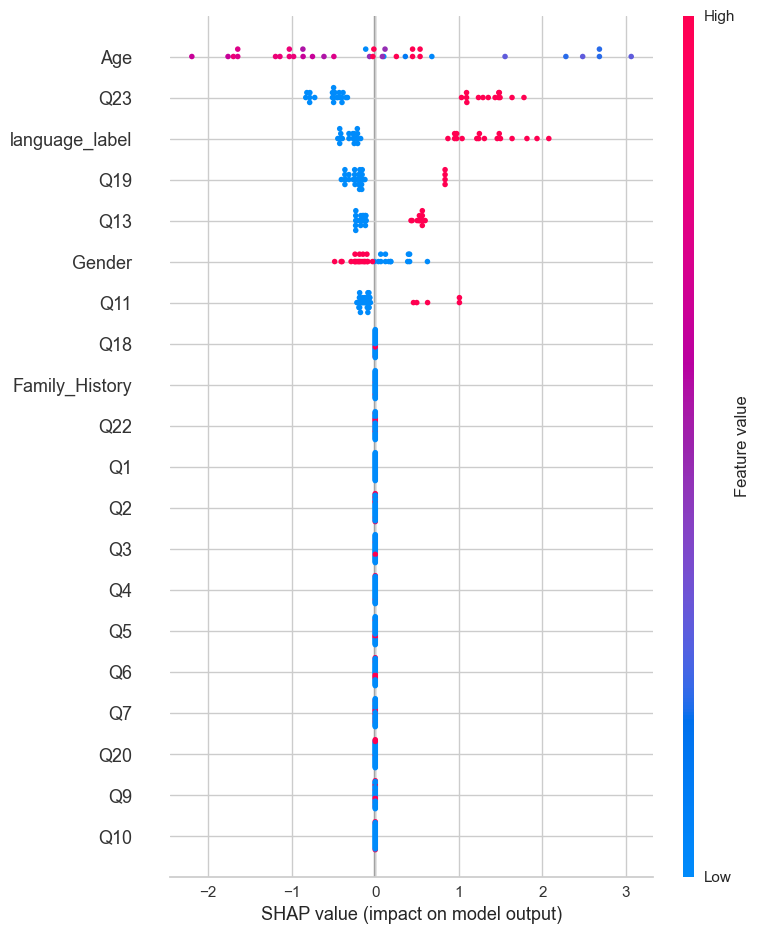

In [168]:
# SHAP 결과
interpret_model(tuned_xgboost, plot = 'summary')
interpret_model(tuned_xgboost, plot = 'msa')

In [142]:
predict_model(tuned_xgboost, data = test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7931,0.7174,1.0000,0.7931,0.8846,0.0000,0.0000


,Subject_Id,Gender,Family_History,SurveyApplicableMonthAge,Age,Q1,Q2,Q3,Q4,Q5,...,Q19,Q20,Q21,Q22,Q23,ethnicity,language_label,Class/ASD,prediction_label,prediction_score
88,1123042711,1,0.0,0,18.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,1,1,0.9932
126,1123112711,1,0.0,0,30.0,0,1,1,0,0,...,0,0,0,1,1,0,1.0,1,1,0.9999
21,1024041433,0,0.0,0,24.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0,1,0.9367
57,1023120582,0,0.0,0,28.0,0,0,0,0,0,...,0,0,0,0,0,0,1.0,1,1,0.9962
75,1024031342,1,0.0,0,28.0,0,0,0,0,0,...,1,0,0,0,0,0,0.0,1,1,0.9517
32,1024052883,0,0.0,0,18.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0,1,0.9953
137,1024021381,1,0.0,0,29.0,0,1,1,0,0,...,0,0,0,1,1,0,1.0,1,1,0.9999
59,1023121362,0,0.0,0,27.0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,1,1,0.5119
63,1323122811,0,0.0,0,24.0,1,1,0,0,0,...,0,0,0,0,1,0,1.0,1,1,0.9999
128,1123122011,1,0.0,0,28.0,0,0,1,0,0,...,0,0,0,0,1,0,1.0,1,1,0.9988
